![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [213]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Import the necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline


# Import GridSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# Import any additional modules and start coding below

# Import Data & EDA

In [214]:
# Read Dataset
df = pd.read_csv('rental_info.csv')

In [215]:
# Show the fields and data types of the data frame
print(df.info())

# Show statisitcs for the df
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB
None


,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
count,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000
mean,4.217161,2006.885379,2.944101,114.994578,20.224727,0.204842,0.200303,0.223378,0.198726,23.355504,14832.841876,11.389287
std,2.360383,2.025027,1.649766,40.114715,6.083784,0.403599,0.400239,0.416523,0.399054,23.503164,9393.431996,10.005293
min,0.990000,2004.000000,0.990000,46.000000,9.990000,0.000000,0.000000,0.000000,0.000000,0.980100,2116.000000,0.980100
25%,2.990000,2005.000000,0.990000,81.000000,14.990000,0.000000,0.000000,0.000000,0.000000,8.940100,6561.000000,0.980100
50%,3.990000,2007.000000,2.990000,114.000000,20.990000,0.000000,0.000000,0.000000,0.000000,15.920100,12996.000000,8.940100
75%,4.990000,2009.000000,4.990000,148.000000,25.990000,0.000000,0.000000,0.000000,0.000000,24.900100,21904.000000,24.900100
max,11.990000,2010.000000,4.990000,185.000000,29.990000,1.000000,1.000000,1.000000,1.000000,143.760100,34225.000000,24.900100


## Define the target variable

In [216]:
# Convert 'rental_date' and 'return_date' from object to datetime
df['rental_date'] = pd.to_datetime(df['rental_date'])
df['return_date'] = pd.to_datetime(df['return_date'])

# Calculate the number of days between 'return_date' and 'rental_date'
df['rental_length_days'] = (df['return_date'] - df['rental_date']).dt.days

# Define the target variable in the df
target = 'rental_length_days'

Frequency of the target
The target variable contains 10 unique values
7    1832
1    1829
8    1771
5    1767
6    1758
4    1757
2    1713
3    1694
9     894
0     846
Name: rental_length_days, dtype: int64


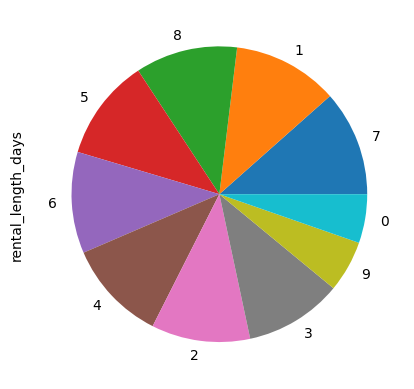

In [217]:
# Show the frequency of the target variable
df[target].value_counts(normalize=True).plot.pie()

# Print Frequency
print('Frequency of the target')
print('The target variable contains {} unique values'.format(len(df[target].unique())))
print(df[target].value_counts())

## Check for Missing

In [218]:
print('Missing Values Check')
print(df.isna().sum())

Missing Values Check
rental_date           0
return_date           0
amount                0
release_year          0
rental_rate           0
length                0
replacement_cost      0
special_features      0
NC-17                 0
PG                    0
PG-13                 0
R                     0
amount_2              0
length_2              0
rental_rate_2         0
rental_length_days    0
dtype: int64


## Convert speacial features to dummy variables

<AxesSubplot: title={'center': 'Special Features Values'}>

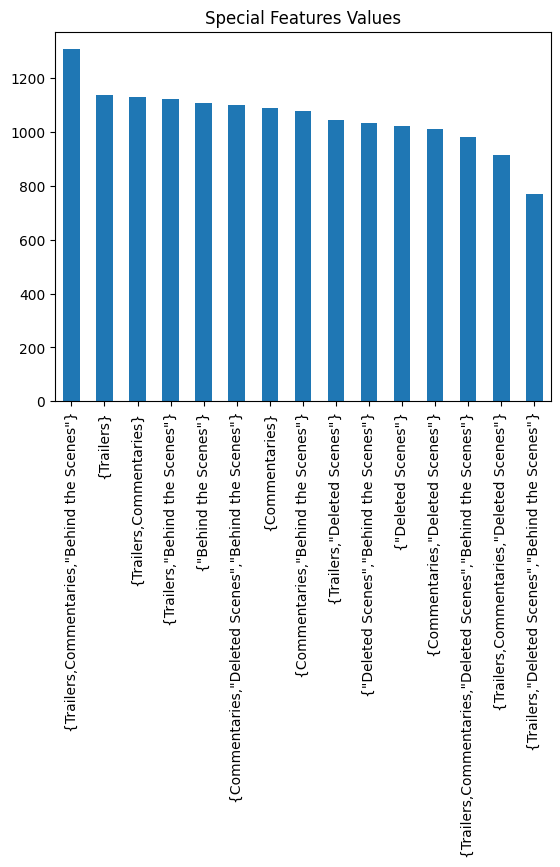

In [219]:
# Review special features values
df['special_features'].value_counts().plot.bar(title='Special Features Values')

In [220]:
# Create dummies (one-hot encoding)
df['sf_deleted_scenes'] = np.where(df['special_features'].str.contains("Deleted Scenes"), 1, 0)
df['sf_behind_scenes'] = np.where(df['special_features'].str.contains("Behind the Scenes"), 1, 0)

# Freq
print(df[['sf_deleted_scenes','sf_behind_scenes']].value_counts())

sf_deleted_scenes  sf_behind_scenes
0                  1                   4616
1                  0                   3997
                   1                   3891
0                  0                   3357
dtype: int64


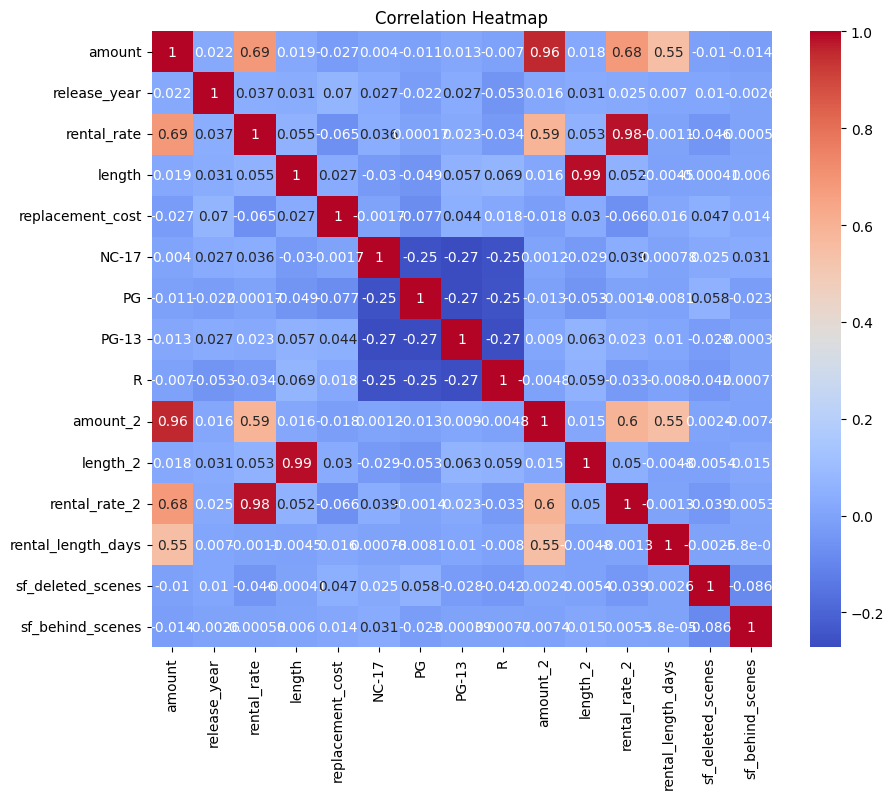

In [221]:
# Create a correlation matrix
corr_matrix = df.corr()

# Set the figure size
plt.figure(figsize=(10, 8))

# Create a heatmap using the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Set the title of the plot
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

# Train Test Split

In [222]:
# Breakout the target (y) and features (X)
X = df.drop([target, 'rental_date', 'return_date', 'special_features'], axis=1).values
y = df[target].values

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, stratify=y)

## Standard Scaler

In [223]:
# Insanitate Standard Scaler
#scaler = StandardScaler()

#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

# Performing Feature Selection

In [224]:
# Instantiate a lasso regression model
lasso = Lasso(alpha=0.3, random_state=9)

# Fit the model to the data
lasso.fit(X_train, y_train)

# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)


[ 5.88808502e-01  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  4.29899042e-02  2.44550602e-06 -1.51535701e-01
 -0.00000000e+00  0.00000000e+00]


In [225]:
# Select features with a positive lasso coeffient
print("Important features with positive Lasso Coeffient are {}".format(X_names[lasso_coef>0].values))

# Subset X_train and X_test
X_lasso_train = X_train[:,lasso_coef>0]
X_lasso_test = X_test[:,lasso_coef>0]



Important features with positive Lasso Coeffient are ['amount' 'amount_2' 'length_2']


# Chosing Models and performing hyperparameter tuning

## Select Models

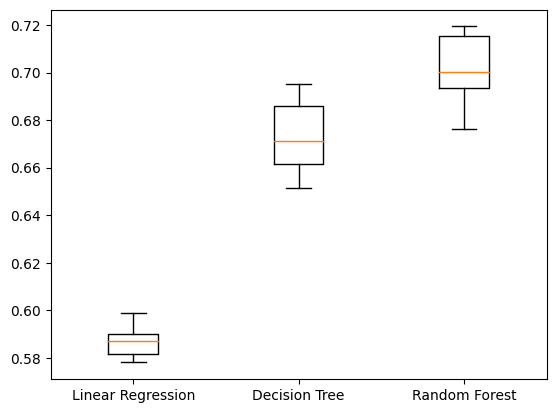

In [226]:
models = {"Linear Regression": LinearRegression(), "Decision Tree" : DecisionTreeRegressor(), "Random Forest" : RandomForestRegressor()}
results = []

# Loop through the models' values
for model in models.values():
  kf = KFold(n_splits=6, random_state=9, shuffle=True)
  
  # Perform cross-validation
  cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
  
  # Append the results
  results.append(cv_scores)

# Create a box plot of the results
plt.boxplot(results, labels=models.keys())
plt.show()

In [227]:
# Run OLS models on lasso chosen regression
ols = LinearRegression()
ols = ols.fit(X_lasso_train, y_train)
y_test_pred = ols.predict(X_lasso_test)
mse_lin_reg_lasso = mean_squared_error(y_test, y_test_pred)

print(mse_lin_reg_lasso)

4.850746588920103


In [228]:
models = {"Linear Regression": LinearRegression(), "Decision Tree" : DecisionTreeRegressor(), "Random Forest" : RandomForestRegressor()}

# Evaluate the models

for name, model in models.items():
  
  # Fit the model to the training data
  model.fit(X_train, y_train)
  
  # Make predictions on the test set
  y_pred = model.predict(X_test)
  
  # Calculate the test_rmse
  test_mse = mean_squared_error(y_test, y_pred, squared=True)
  print("{} Test Set MSE: {}".format(name, test_mse))

Linear Regression Test Set MSE: 2.8749774843859157
Decision Tree Test Set MSE: 2.204527726705902
Random Forest Test Set MSE: 2.0814333043130726


## Tuning Model

In [229]:
# Instantiate dt
dt = DecisionTreeRegressor(max_depth=8,
             min_samples_leaf=0.13,
            random_state=9)

# Fit dt to the training set
dt.fit(X_train, y_train)

# Compute y_pred
y_pred = dt.predict(X_test)

# Compute mse_dt
mse_dt =  mean_squared_error(y_test, y_pred, squared=True)

# Print rmse_dt
print("Test set RMSE of dt: {:.2f}".format(mse_dt))

Test set RMSE of dt: 3.23


In [230]:
# Define the dictionary 'params_rf'
params_dt = {'max_features' : ['log2', 'auto', 'sqrt'],
            'min_samples_leaf' : [2, 10, 30]}

# Instantiate grid_dt
grid_dt = GridSearchCV(estimator=dt,
                       param_grid=params_dt,
                       scoring='neg_mean_squared_error',
                       cv=3,
                       verbose=1,
                       n_jobs=-1)

# Fit the model
grid_dt.fit(X_train, y_train)  # Corrected from grid_object.fit to grid_dt.fit

# Extract the best estimator
best_model = grid_dt.best_estimator_

# Predict test set labels
y_pred = best_model.predict(X_test)

# Compute MSE
grid_dt_mse = mean_squared_error(y_test, y_pred, squared=True)

# Print mse_test
print('Test MSE of best model: {:.3f}'.format(grid_dt_mse))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Test MSE of best model: 2.387


In [231]:
# Random forest hyperparameter space
param_dist = {'n_estimators': np.arange(1,101,1),
          'max_depth':np.arange(1,11,1)}

# Create a random forest regressor
rf = RandomForestRegressor()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions=param_dist, 
                                 cv=5, 
                                 random_state=9)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best hyper param
hyper_params = rand_search.best_params_

# Run the random forest on the chosen hyper parameters
rf = RandomForestRegressor(n_estimators=hyper_params["n_estimators"], 
                           max_depth=hyper_params["max_depth"], 
                           random_state=9)
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
mse_random_forest= mean_squared_error(y_test, rf_pred)

# Print rmse_test
print('Test MSE of best model: {:.3f}'.format(mse_random_forest))


Test MSE of best model: 2.165


In [232]:
# Best MSE
best_mse = mse_random_forest

# Print MSE 2.225667528098759
print(f"Best MSE is {best_mse}")

Best MSE is 2.164534523406932
